In [3]:
!pip install gensim numpy matplotlib pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 58.1 MB/s eta 0:00:00


Loading embeddings from OperaLatina.vec.txt ...
Loaded.
Loading embeddings from OperaMaiora.vec.txt ...
Loaded.
Common vocabulary size: 14101
Computing cosine similarities for common vocabulary...


100%|██████████| 14101/14101 [00:00<00:00, 28781.14it/s]



STATISTICS & THRESHOLDS
Среднее (μ)             = -0.1476
Медиана                 = -0.1494
Стандартное отклонение (σ) = 0.1739
--------------------
Порог -1σ (нижняя граница нормы)   = -0.3216
Порог +1σ (верхняя граница нормы)  = 0.0263
Порог -2σ (граница выраж. сдвига)  = -0.4955
Порог +2σ (граница повыш. стаб.)   = 0.2002

Проверка эмпирического распределения:
  В интервале μ ± 1σ :  65.51%  (теоретически ~68%)
  В интервале μ ± 2σ :  96.63%  (теоретически ~95%)
  Вне интервала μ ± 2σ:   3.37%  (теоретически ~5%)

1) Максимальный семантический сдвиг (наименьшее сходство):
Слово: laocoon         Сходство: -0.7083
Слово: chelys          Сходство: -0.6872
Слово: iapyx           Сходство: -0.6822
Слово: hamadryades     Сходство: -0.6808
Слово: pegasus         Сходство: -0.6712
Слово: cybebe          Сходство: -0.6612
Слово: sisyphius       Сходство: -0.6495
Слово: chalybs         Сходство: -0.6346
Слово: parnasus        Сходство: -0.6297
Слово: sipylus         Сходство: -0.6282

2) Мин

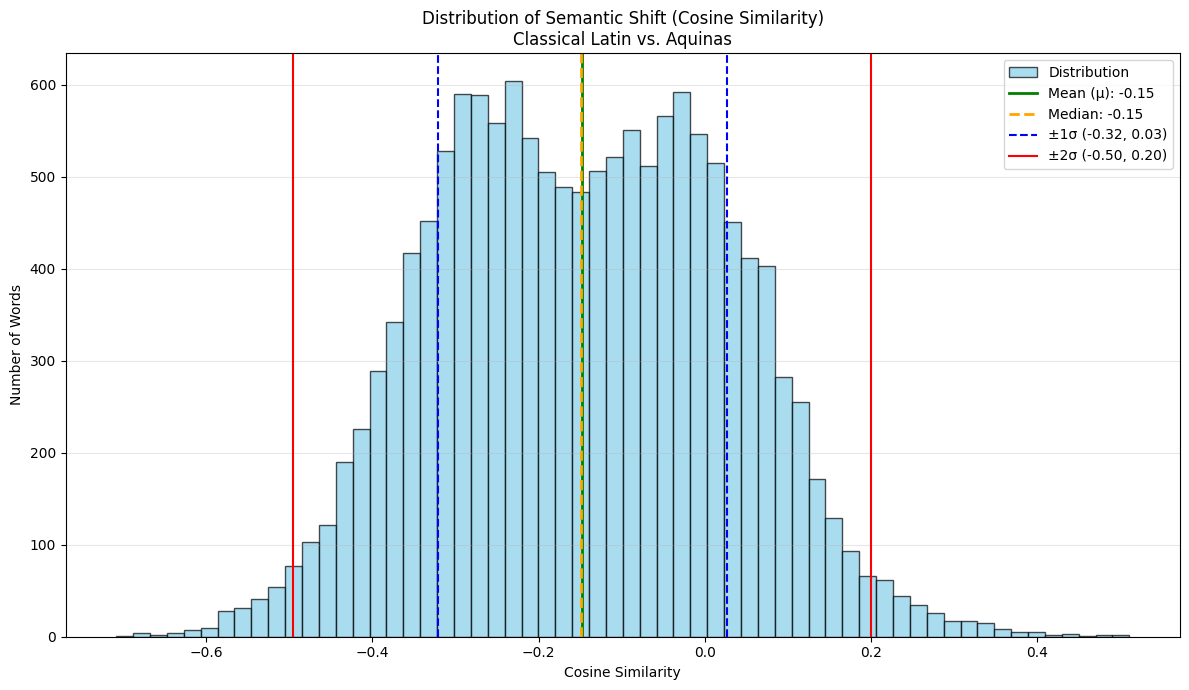

Full results saved to classical_aquinas_cosine_full.csv


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from numpy.linalg import norm
from tqdm import tqdm
import pandas as pd

# =========================
# CONFIG
# =========================
CLASSICAL_MODEL_URL = 'https://embeddings.lila-erc.eu/samples/download/aligned/OperaLatina.vec.txt'
AQUINAS_MODEL_URL   = 'https://embeddings.lila-erc.eu/samples/download/aligned/OperaMaiora.vec.txt'

CLASSICAL_FILE = "OperaLatina.vec.txt"
AQUINAS_FILE   = "OperaMaiora.vec.txt"

# -------------------------
# Helper: download file if missing
# -------------------------
def download_if_missing(url, filename):
    if not os.path.exists(filename):
        print(f"Downloading {filename} ...")
        os.system(f"wget -O {filename} {url}")
    else:
        print(f"{filename} already exists, skipping download.")

# =========================
# 1. DOWNLOAD MODELS
# =========================
download_if_missing(CLASSICAL_MODEL_URL, CLASSICAL_FILE)
download_if_missing(AQUINAS_MODEL_URL, AQUINAS_FILE)

# =========================
# 2. LOAD MODELS
# =========================
print("Loading embeddings from", CLASSICAL_FILE, "...")
model_classical = KeyedVectors.load_word2vec_format(CLASSICAL_FILE, binary=False)
print("Loaded.")

print("Loading embeddings from", AQUINAS_FILE, "...")
model_aquinas   = KeyedVectors.load_word2vec_format(AQUINAS_FILE, binary=False)
print("Loaded.")

# =========================
# 3. COMMON VOCAB & SIMILARITY CALCULATION
# =========================
common_vocab = list(set(model_classical.key_to_index) & set(model_aquinas.key_to_index))
print("Common vocabulary size:", len(common_vocab))

print("Computing cosine similarities for common vocabulary...")

similarities = []

# Используем цикл для явного контроля и создания списка кортежей (слово, сходство)
for lemma in tqdm(common_vocab):
    v_cl = model_classical.get_vector(lemma)
    v_aq = model_aquinas.get_vector(lemma)
    # Косинусное сходство: dot(a, b) / (|a| * |b|)
    sim = np.dot(v_cl, v_aq) / (norm(v_cl) * norm(v_aq))
    similarities.append((lemma, sim))

# Преобразуем в DataFrame для удобства
df = pd.DataFrame(similarities, columns=['word', 'similarity'])

# =========================
# 4. ОБЩАЯ СТАТИСТИКА (metrics & thresholds)
# =========================
cos_values = df['similarity'].values
mu = cos_values.mean()
sigma = cos_values.std(ddof=1)   # выборочное стандартное отклонение
median = np.median(cos_values)

# Рассчитываем пороги (Mean ± k*Sigma)
sd1_low  = mu - sigma
sd1_high = mu + sigma
sd2_low  = mu - 2 * sigma
sd2_high = mu + 2 * sigma

print("\n" + "="*40)
print("STATISTICS & THRESHOLDS")
print("="*40)
print(f"Среднее (μ)             = {mu:.4f}")
print(f"Медиана                 = {median:.4f}")
print(f"Стандартное отклонение (σ) = {sigma:.4f}")
print("-" * 20)
print(f"Порог -1σ (нижняя граница нормы)   = {sd1_low:.4f}")
print(f"Порог +1σ (верхняя граница нормы)  = {sd1_high:.4f}")
print(f"Порог -2σ (граница выраж. сдвига)  = {sd2_low:.4f}")
print(f"Порог +2σ (граница повыш. стаб.)   = {sd2_high:.4f}")

# Проверка эмпирического правила 68-95-99.7
mask_1sigma = (cos_values >= sd1_low) & (cos_values <= sd1_high)
mask_2sigma = (cos_values >= sd2_low) & (cos_values <= sd2_high)
mask_outside_2sigma = ~mask_2sigma

p_1sigma = mask_1sigma.mean()
p_2sigma = mask_2sigma.mean()
p_outside = mask_outside_2sigma.mean()

print("\nПроверка эмпирического распределения:")
print(f"  В интервале μ ± 1σ : {p_1sigma*100:6.2f}%  (теоретически ~68%)")
print(f"  В интервале μ ± 2σ : {p_2sigma*100:6.2f}%  (теоретически ~95%)")
print(f"  Вне интервала μ ± 2σ: {p_outside*100:6.2f}%  (теоретически ~5%)")

# =========================
# 5. ТОП-10 ИЗМЕНИВШИХСЯ И СТАБИЛЬНЫХ СЛОВ
# =========================
# Сортировка по возрастанию (самые маленькие значения = сильный сдвиг)
df_sorted = df.sort_values(by='similarity', ascending=True)

print("\n" + "="*40)
print("1) Максимальный семантический сдвиг (наименьшее сходство):")
print("="*40)
top_shift = df_sorted.head(10)
for idx, row in top_shift.iterrows():
    print(f"Слово: {row['word']:<15} Сходство: {row['similarity']:.4f}")

# Сортировка по убыванию (самые большие значения = минимальный сдвиг)
print("\n" + "="*40)
print("2) Минимальный семантический сдвиг (наибольшее сходство/стабильность):")
print("="*40)
top_stable = df_sorted.tail(10).iloc[::-1] # берем хвост и разворачиваем
for idx, row in top_stable.iterrows():
    print(f"Слово: {row['word']:<15} Сходство: {row['similarity']:.4f}")


# =========================
# 6. ГИСТОГРАММА РАСПРЕДЕЛЕНИЯ
# =========================
print("\nBuilding histogram...")

plt.figure(figsize=(12, 7))
# Гистограмма
n, bins, patches = plt.hist(cos_values, bins=60, color='skyblue', edgecolor='black', alpha=0.7, label='Distribution')

# Вертикальные линии для среднего и сигм
plt.axvline(mu, color='green', linestyle='-', linewidth=2, label=f'Mean (μ): {mu:.2f}')
plt.axvline(median, color='orange', linestyle='--', linewidth=2, label=f'Median: {median:.2f}')

plt.axvline(sd1_low, color='blue', linestyle='--', linewidth=1.5, label=f'±1σ ({sd1_low:.2f}, {sd1_high:.2f})')
plt.axvline(sd1_high, color='blue', linestyle='--', linewidth=1.5)

plt.axvline(sd2_low, color='red', linestyle='-', linewidth=1.5, label=f'±2σ ({sd2_low:.2f}, {sd2_high:.2f})')
plt.axvline(sd2_high, color='red', linestyle='-', linewidth=1.5)

# Подписи осей и заголовок
plt.xlabel('Cosine Similarity')
plt.ylabel('Number of Words')
plt.title('Distribution of Semantic Shift (Cosine Similarity)\nClassical Latin vs. Aquinas')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Сохранение и показ
hist_filename = 'semantic_shift_histogram_combined.png'
plt.savefig(hist_filename, dpi=300)
print(f"Histogram saved to {hist_filename}")
plt.show()

# =========================
# 7. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ В CSV
# =========================
csv_filename = "classical_aquinas_cosine_full.csv"
df.to_csv(csv_filename, index=False)
print(f"Full results saved to {csv_filename}")
